# Hardy-Hénon型熱方程式の数値解析

## 序章

ここでは, Hardy-Hénon型熱方程式と呼ばれる以下の方程式を考える.

\begin{align*}
\left \{
\begin{aligned}
& \partial_t u - \Delta u = \frac{|u|^{\alpha - 2}u}{|x|^{\gamma}},
\quad (t,x) \in \mathbf{R}_+ \times \mathbf{R}, \\
& u(0,x)=u_0(x).
\end{aligned}
\right.
\end{align*}

ただし, $0 \le \gamma<1$, $\alpha>2$ とする.

この方程式の特徴は, 非線形項が原点 $x = 0$ で特異性を持つことにある. なお, $\gamma=0$ の場合は特異性を持たず, 通常の半線形熱方程式となる.

以下では, **小さい初期値に対する解の漸近挙動**を調べる目的で, 数値解析を行う.

## 準備

各パラメータは以下の通り設定する:

\begin{align*}
& \alpha = 3, \\
& \gamma = 0, \, 0.25, \, 0.5, \, 0.75.
\end{align*}

また, 初期値は以下の関数とする:

\begin{align*}
u_0(x) = \frac{1}{4} \mathrm{e}^{-10x^2}
\end{align*}

さらに, 解は空間遠方で十分早く減衰しているとして, 区間 $[-1, 1] $ 上で境界値 $0$ のディリクレ問題を解くこととする.
結局, 以下の方程式を数値的に解くことを考える.

\begin{align*}
\left \{
\begin{aligned}
& \partial_t u - \Delta u = \frac{|u|u}{|x|^{\gamma}},
\quad (t,x) \in \mathbf{R}_+ \times (-1, 1), \\
& u(0,x)=\frac{1}{4} \mathrm{e}^{-10x^2}, \\
&u(t,-1)=u(t,1)=0.
\end{aligned}
\right.
\end{align*}



## 離散化

離散化手法としては, 時間微分には前進差分, ラプラシアンには2階中心差分を用いることとし, 非線形項は離散点の値をそのまま使う. 
ただし, 原点に特異性があるため, 原点だけは別の扱いをする必要がある.
ここでは, 原点周りのみ有限要素法における集中質量近似を用いて, 特異性を回避することとする. 
実際, $0 \le \gamma<1$ より, $|x|^{- \gamma}$ は原点周りで積分可能である.

まとめると, 以下の通り方程式を離散化する:
    
\begin{align*}
u^{n+1}_{i} = 
\left \{
\begin{aligned}
& u^{n}_{i} + 
\frac{\Delta t}{{\Delta x}^2} (u^{n}_{i+1} - 2 u^{n}_{i} + u^{n}_{i-1})
+ \Delta t \frac{|u^{n}_{i}|u^{n}_{i}}{|x_{i}|^{\gamma}}, \quad (x_{i} \neq 0), \\
& u^{n}_{i} + 
\frac{\Delta t}{{\Delta x}^2} (u^{n}_{i+1} - 2 u^{n}_{i} + u^{n}_{i-1}) 
+ 2^{\gamma} \Delta t \frac{|u^{n}_{i}|u^{n}_{i}}{{(\Delta x)}^{\gamma}}, \quad (x_{i} = 0).
\end{aligned}
\right.
\end{align*}    

## 実装と解析結果

上記に従い, Pythonで実装した. なお, 比較のために線形の熱方程式も同時に計算した.

<IPython.core.display.Javascript object>


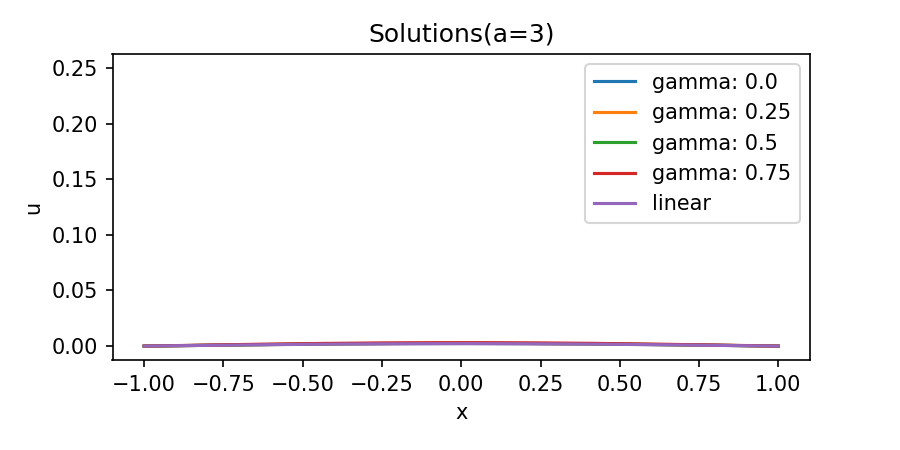

<IPython.core.display.Javascript object>


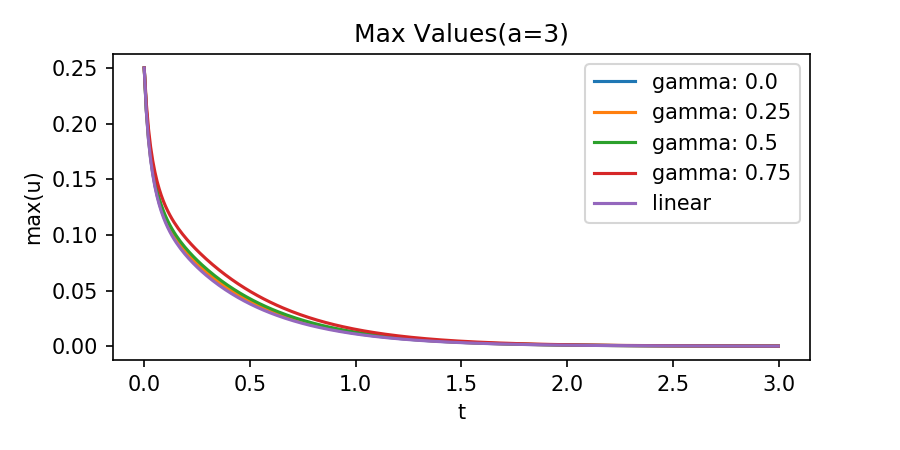

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, exp, real, imag
from scipy.fftpack import fft, ifft, fftfreq
import warnings
warnings.filterwarnings("ignore")

#空間
L_end = -1
R_end = 1
N = 2**8 + 1
x = np.linspace(L_end, R_end, N)
dx = (R_end - L_end)/N
origin_idx = int((len(x)-1)/2)

# 時間
T = 3
dt = (dx ** 2) * 1/6
maxstep = int(T / dt)

# 微分方程式の計算

# gamma
gammas = np.linspace(0, 0.75, 4)
gammas = np.append(gammas, 0) # 線形方程式用

# 境界値
L_BV = 0
R_BV = 0

# 初期値
alpha = 1/4
beta = 10
u = alpha * exp(-beta * (x**2))
u = np.tile(u, (len(gammas), 1))
u[:, 0] = L_BV
u[:, -1] = R_BV

# 定数
c1 = dt/(dx**2)
c2 = np.zeros_like(u)
for i, gamma in enumerate(gammas):
    c2[i, 0:origin_idx] = abs(x[0:origin_idx]) ** (-gamma)
    c2[i, origin_idx+1:] = abs(x[origin_idx+1:]) ** (-gamma)
    c2[i, origin_idx] = (2**gamma) * (dx**(-gamma))
c2[-1] = 0 # 線形方程式用
c2 = dt * c2
a = 3 # 非線形項の冪

# 結果格納用
fig = plt.figure(figsize=(6,3))
fig.subplots_adjust(bottom=0.2)
ims = []
cmap = plt.get_cmap("tab10")
max_vals = []
labels = []
for gamma in gammas:
    labels.append("gamma: " + str(gamma))
labels[-1] = "linear" # 線形方程式用
    
for n in range(maxstep):
    u[:, 1:-1] += c1 * (u[:, 2:] - 2*u[:, 1:-1] + u[:, 0:-2]) + c2[:, 1:-1] * abs(u[:, 1:-1])**(a-2) * u[:, 1:-1]
    u[:, 0] = L_BV
    u[:, -1] = R_BV
    
    if n % 1000 < 1e-10: 
        im = []
        for i in range(len(gammas)):
            im += plt.plot(x, u[i,:], color=cmap(i))
        ims.append(im)
        max_val = []
        for i in range(len(gammas)):
            max_val.append(np.max(u[i, :]))
        max_vals.append(max_val)

plt.title("Solutions(a=3)")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(labels)
ani = animation.ArtistAnimation(fig, ims, interval=1)

fig2 = plt.figure(figsize=(6,3))
fig2.subplots_adjust(bottom=0.2)
for i in range(len(gammas)):
    plt.plot(dt * 1000 * np.array(range(len(max_vals))), np.array(max_vals)[:, i], color=cmap(i), label = labels[i])
plt.title("Max Values(a=3)")
plt.xlabel("t")
plt.ylabel("max(u)")
plt.legend()

plt.show()
ani.save(f"results\Hardy_Henon_a-3.gif", savefig_kwargs={"bbox_inches":"tight"})
plt.savefig(f"results\Hardy_Henon_maxval_a-3.png", bbox_inches="tight")
        

## 結論

小さい初期値に対するHardy-Hénon型熱方程式の解の漸近挙動は, 少なくとも低次については, 半線形熱方程式および線形熱方程式と同様になると予想される. 

注) 完全に一致するという意味ではない. 適切な修正のもと, 本質的に同じものと見なせるだろうということである.

## 参考

・K.Taniguchi(N.Chikami, M.Ikeda), Well-posedness and global dynamics for the critical Hardy-Hénon parabolic equation, Well-posedness Zoomセミナー